In [1]:
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style("darkgrid")
import scipy
from scipy import stats
from scipy import signal
sns.plt = plt
np.random.seed(1) # No estoy seguro si es necesario

mail = """
Hola a todos

Varios me preguntaron del formato de los archivos .mat

Cada .mat corresponde a un paciente y contiene una matriz tridimensional: trials/epochs x electrodos x muestras en Epoch

Por ejemplo, El archivo P01 tiene 864 epochs (primer dimensión). Eso quiere decir que de los 1200 ensayos que se hicieron con ese paciente solo 864 sobrevivieron al filtrado y preprocesamiento.

Espero que esto aclare un poco...


"""


In [2]:
mat = scipy.io.loadmat('datos/P01.mat')
mm = mat['data']

# Epoch = sonidito
# Electrodos = 256
# Tiempos = 201
# Epoch = 894
# Epochs  x Electrodos  x Tiempo
print mm[0][0][0]
print mm.shape


9.5019053032e-06
(894, 256, 201)


In [3]:
#
# a) Computar uno de los posibles análisis espectrales.

# a.1) Calcular la media entre los electrodos 8, 44, 80, 131 y 185 (el primer electrodo es el 0) 
# y realizar una figura que muestre las frecuencias en el eje Y, los epochs en el eje X
# , y la potencia usando una escala de color como en el ejemplo:


In [4]:
electrodo8 = mm[:, 7, :]
electrodo44 = mm[:, 43, :]
electrodo80 = mm[:, 79, :]
electrodo131 = mm[:, 130, :]
electrodo185 = mm[:, 184, :]

electrodos = [electrodo8, electrodo44, electrodo80, electrodo131, electrodo185]


In [5]:
def averageTimeSeries(tsList):
    for i in range(len(tsList[0])):
        yield np.mean(map(lambda ts: ts[i], tsList))

def averageInEpoch(epoch_idx):
    return averageTimeSeries(map(lambda electrodo: electrodo[epoch_idx], electrodos))


def senal_suavizada(ts):
    return pd.ewma(pd.Series(ts), com=5.0)


In [11]:
averagedElectrodesByEpoch = [list(senal_suavizada(averageInEpoch(i))) for i in range(894)] 
# Primer Epoch

plt.show()


#data={'epoca': range(894),
#      'frequ': epoch0_welch[0]
#      'pot'  : [epoch0_welch[1], epoch1_welch[1], ]
#     } 

#averagedEpochs = pd.DataFrame(data=data, columns=['epochs', 'frecuencas', 'potencias'])

def freq_pots_relevantes(freqs, pots):
    pairs_relevantes = filter(lambda x: x[0] <= 0.045, zip(freqs, pots))
    freqs_relevantes = map(lambda x: x[0], pairs_relevantes)
    amplitudes_relevantes = map(lambda x: x[1], pairs_relevantes)
    return (freqs_relevantes, amplitudes_relevantes)
    

allEpochs = pd.DataFrame();
for i in range(894):
    epoch_welch = scipy.signal.welch(averagedElectrodesByEpoch[i])
    frecuencas_sampleadas = epoch_welch[0]; # Deberia ser siempre lo mismo
    (freqs_relevantes, pots_relevantes) = freq_pots_relevantes(frecuencas_sampleadas, epoch_welch[1])
    allEpochs = allEpochs.append(pd.DataFrame(pots_relevantes).transpose());
    
allEpochs = allEpochs.reset_index();

print allEpochs

# No se por que aparece mil veces el dataframe printeado
# Arreglar eso
# crei que los ';' lo arreglaban pero no

/home/brian/Documents/facultad/cienciadatos/venv/lib/python2.7/site-packages/ipykernel_launcher.py:10: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(ignore_na=False,min_periods=0,adjust=True,com=5.0).mean()
  # Remove the CWD from sys.path while we load stuff.


     index             0             1             2             3  \
0        0  4.383993e-10  1.053702e-09  6.167368e-10  2.984891e-10   
1        0  5.989904e-11  2.879561e-10  6.805478e-10  3.531608e-10   
2        0  1.086119e-10  7.770359e-10  2.968853e-10  1.135697e-10   
3        0  3.947688e-11  4.411449e-10  1.559105e-10  2.825892e-11   
4        0  2.279521e-10  1.857203e-09  9.726173e-10  1.831530e-10   
5        0  9.482870e-11  6.299266e-10  9.905513e-11  1.388367e-10   
6        0  3.157119e-10  2.263892e-09  1.068865e-09  1.811139e-10   
7        0  8.693535e-13  4.888016e-10  3.859872e-10  3.986266e-10   
8        0  2.174693e-10  1.896102e-09  1.031628e-09  9.435196e-11   
9        0  2.484402e-10  5.019169e-10  3.162963e-10  3.893139e-10   
10       0  1.809195e-10  6.164162e-10  1.205388e-10  3.378294e-11   
11       0  4.865310e-11  5.484489e-10  1.038963e-10  1.353885e-12   
12       0  5.686850e-11  1.327831e-10  8.832169e-11  1.817413e-10   
13       0  1.272258

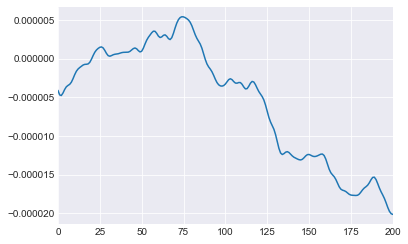

In [12]:

# Viendo este grafico creo que habia que suavizar la funcion
# Capaz asi el grafico de arriba se pone mas interesante


sns.tsplot(averagedElectrodesByEpoch[20])
plt.show()

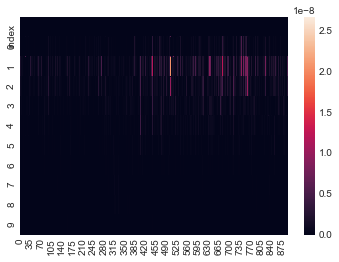

In [13]:
sns.heatmap(allEpochs.transpose())#, cmap=sns.color_palette("Blues") )
plt.show()



In [14]:
def calc_potencias(electrodo_idx):
    def get_epoch(epoch_idx):
        epoch = mm[epoch_idx, electrodo_idx, :]
        return epoch
    def potencias_epoch(epoch_idx):
        welch_result = scipy.signal.welch(get_epoch(epoch_idx))
        (freqs_relevantes, pots_relevantes) = freq_pots_relevantes(welch_result[0], welch_result[1])
        return pots_relevantes
    potencias = [potencias_epoch(i) for i in range(894)]
    res = []
    for i in range(len(potencias[0])):
        res.append(np.average([pot[i] for pot in potencias]))
    return res

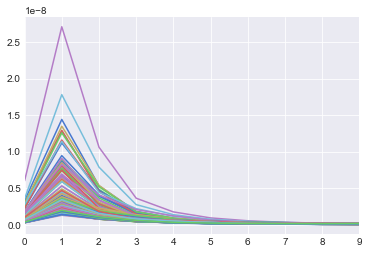

In [17]:


colors = sns.color_palette("muted", n_colors=250)

for i in range(200):
    sns.tsplot(calc_potencias(i), color=colors[i])
plt.show()
